In [2]:
%matplotlib inline
# import functions from python directory
import sys
# sys.path.append("/home/bgreene/SBL_LES/python/")
import seaborn
import cmocean
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from LESnc import load_full#, load_timeseries

In [3]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')
cmap = seaborn.color_palette("Spectral", as_cmap=True)
cmap2 = seaborn.color_palette("cubehelix_r", as_cmap=True)

In [5]:
# directories
# figure save
figdir = "/home/rfrost/"
# list of simulations to loop over
sims = ["agu_1", "agu_2", "agu_3", "agu_4"]
# empty list to construct paths and store
dnc_all = []
for sim in sims:
    dnc = f"/home/rfrost/sim_output/linear_flux/{sim}/"
    dnc_all.append(dnc)

# Case 1
timesteps 0680000 -- 1260000

output every 1000 timesteps

timestep = 0.05 s

want to grab the following:

-constant beginning (@ 15 min)

-mid ramp-up (@ 1 hr)

-beginning of constant high (@ 2 hr)

-end of constant high (@ 4 hr)

-mid ramp-down (@ 5 hr)

-constant end (@ 7 hr)

In [6]:
timesteps = np.arange(648000, 1260001, 1000, dtype=np.int32)
t = (0.05 * timesteps)/3600. - 9 # reset to 0
# grab the timesteps for loading
# array of times
tload = np.array([0.25, 1.0, 2.0, 4.0, 5.0, 7.0]) # hrs
# loop to find nearest timestep
jt1 = np.array([np.argmin(np.abs(t - tt)) for tt in tload])
# number of timesteps
nt = len(tload)
# define colormap
colors = seaborn.color_palette("cubehelix_r", nt)

In [7]:
timesteps.size

613

### Begin loading data

In [8]:
# construct filenames
f1 = [f"{dnc_all[2]}all_{timesteps[jt]:07d}.nc" for jt in jt1]
# load mf dataset
d1 = xr.open_mfdataset(f1, combine="nested", concat_dim="time")
d1.coords["time"] = t[jt1]
d1.time.attrs["units"] = "hr"

In [9]:
# calculate "inst" covar based on xy planar averages
# averages and perturbations
for v in ["u", "v", "w", "theta"]:
    d1[f"{v}_mean"] = d1[v].mean(dim=("x", "y"))
    d1[f"{v}_pert"] = d1[v] - d1[f"{v}_mean"]
# covars
d1["uw"] = (d1.u - d1.u_mean) * (d1.w - d1.w_mean) + d1.txz
d1["vw"] = (d1.v - d1.v_mean) * (d1.w - d1.w_mean) + d1.tyz
d1["tw"] = (d1.theta - d1.theta_mean) * (d1.w - d1.w_mean) + d1.q3
# vars
d1["uu"] = (d1.u - d1.u_mean) * (d1.u - d1.u_mean)
d1["vv"] = (d1.v - d1.v_mean) * (d1.v - d1.v_mean)
d1["ww"] = (d1.w - d1.w_mean) * (d1.w - d1.w_mean)
d1["tt"] = (d1.theta - d1.theta_mean) * (d1.theta - d1.theta_mean)

# calculate averages
d1["uw_cov_tot"] = d1.uw.mean(dim=("x","y"))
d1["vw_cov_tot"] = d1.vw.mean(dim=("x","y"))
d1["tw_cov_tot"] = d1.tw.mean(dim=("x","y"))
d1["uu_var"] = d1.uu.mean(dim=("x","y"))
d1["vv_var"] = d1.vv.mean(dim=("x","y"))
d1["ww_var"] = d1.ww.mean(dim=("x","y"))
d1["tt_var"] = d1.tt.mean(dim=("x","y"))
# calculate ustar
d1["ustar2"] = ((d1.uw_cov_tot**2) + (d1.vw_cov_tot**2.)) ** 0.5
# calculate vorticity
d1["vort_x"] = d1.w_pert.differentiate("y", 2) - d1.v_pert.differentiate("z", 2)
d1["vort_y"] = d1.u_pert.differentiate("z", 2) - d1.w_pert.differentiate("x", 2)
d1["vort_z"] = d1.v_pert.differentiate("x", 2) - d1.u_pert.differentiate("y", 2)
d1["vort_mag_2"] = d1.vort_x*d1.vort_x + d1.vort_y*d1.vort_y + d1.vort_z*d1.vort_z

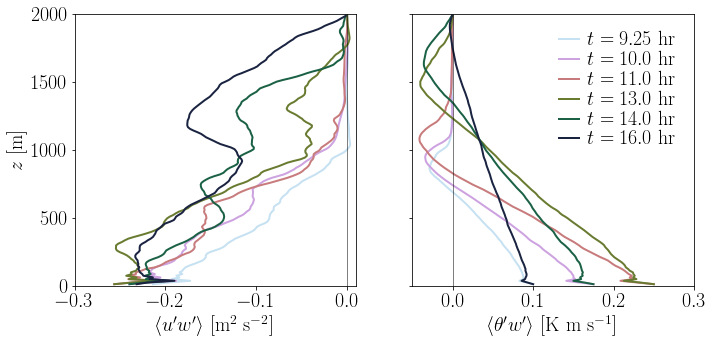

In [8]:
# plot profiles of momentum and heat flux
fig1, ax1 = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(11.1, 5))
# loop over timesteps
for jt in range(nt):
    ax1[0].plot(d1.uw_cov_tot.isel(time=jt), d1.z, label=f"$t={{{9+d1.time[jt].values}}}$ hr",
                lw=2, c=colors[jt])
    ax1[1].plot(d1.tw_cov_tot.isel(time=jt), d1.z, label=f"$t={{{9+d1.time[jt].values}}}$ hr", 
                lw=2, c=colors[jt])
# legend
ax1[1].legend(frameon=False, labelspacing=0.10,# ncol=2, columnspacing=1,
                handletextpad=0.4, handlelength=1, loc="upper right")
# axis limits
ax1[0].set_ylim([0, 2000])
ax1[0].set_xlim([-0.3, 0.01])
ax1[1].set_xlim([-0.05, 0.3])
# axis lbels
ax1[0].set_ylabel("$z$ [m]")
ax1[0].set_xlabel("$\\langle u'w' \\rangle$ [m$^2$ s$^{-2}$]")
ax1[1].set_xlabel("$\\langle \\theta'w' \\rangle$ [K m s$^{-1}$]")
# vertical thin lines at 0
for iax in ax1:
    iax.axvline(0, ls="-", c="k", lw=0.5)

### Instantaneous $\theta' w'$

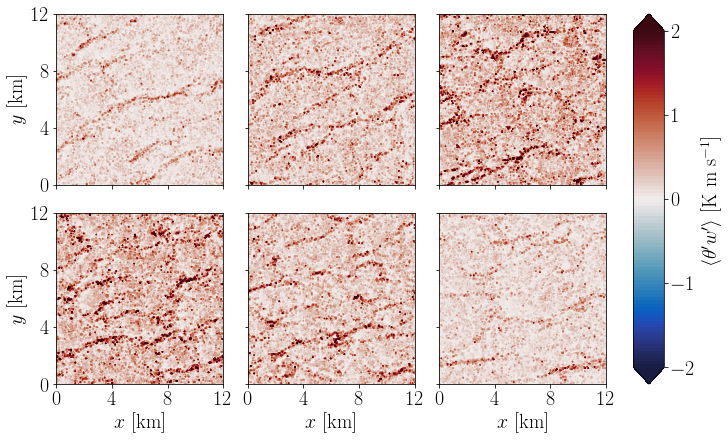

In [11]:
# loop over sims and plot for z = 100 m
jz = abs(d1.z - 100.0).argmin()
# make 6-panel plot
fig1, ax1 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 6))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
leveltw = np.linspace(-2, 2, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax1.flatten()):
    # contour
    cfax = iax.contourf(d1.x/1000, d1.y/1000, d1.tw.isel(time=jt, z=jz).T,
                        levels=leveltw, cmap=cmocean.cm.balance, extend="both")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig1.colorbar(cfax1[0], ax=ax1[:,-1], location="right", ticks=MultipleLocator(1))
# cb label
cb.ax.set_ylabel("$\\langle \\theta' w' \\rangle$ [K m s$^{-1}$]")
# axis limits
ax1[0,0].set_xlim([0, 12])
ax1[0,0].set_ylim([0, 12])
# axis ticks
ax1[0,0].xaxis.set_major_locator(MultipleLocator(4))
ax1[0,0].yaxis.set_major_locator(MultipleLocator(4))
# axis labels
for iax in ax1[:,0]:
    iax.set_ylabel("$y$ [km]")
for iax in ax1[-1,:]:
    iax.set_xlabel("$x$ [km]")

### $w'$

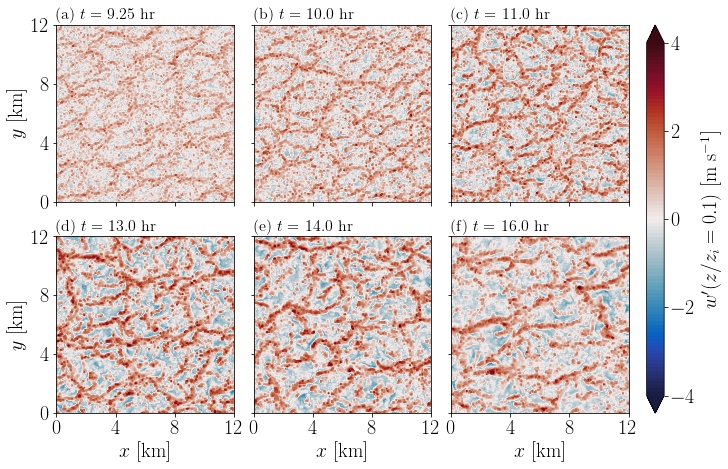

In [10]:
# loop over sims and plot for z = 100 m
# jz = abs(d1.z - 100.0).argmin()
# make 6-panel plot
fig1, ax1 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 6.4))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
levelw = np.linspace(-4, 4, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax1.flatten()):
    # calc z/zi
    # calculate zi
    jzi = d1.tw.isel(time=jt).mean(dim=("x","y")).argmin().values
    zzi = d1.z/d1.z[jzi]
    # find jz for z/zi = 0.1
    jz = abs(zzi - 0.1).argmin()
    # contour
    cfax = iax.contourf(d1.x/1000, d1.y/1000, d1.w_pert.isel(time=jt, z=jz).T,
                        levels=levelw, cmap=cmocean.cm.balance, extend="both")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig1.colorbar(cfax1[0], ax=ax1[:,-1], location="right", ticks=MultipleLocator(2))
# cb label
cb.ax.set_ylabel(f"$w'(z/z_i=0.1)$ [m s$^{{{-1}}}$]")
# axis limits
ax1[0,0].set_xlim([0, 12])
ax1[0,0].set_ylim([0, 12])
# axis ticks
ax1[0,0].xaxis.set_major_locator(MultipleLocator(4))
ax1[0,0].yaxis.set_major_locator(MultipleLocator(4))
# axis labels
for iax in ax1[:,0]:
    iax.set_ylabel("$y$ [km]")
for iax in ax1[-1,:]:
    iax.set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax1.flatten(), list("abcdef"))):
    iax.set_title(f"({lab}) $t =$ {9+d1.time[jt].values} hr", fontsize=16, loc="left")
# save figure
fsave = f"{figdir}agu1_w_zzi_6panel.png"
fig1.savefig(fsave, dpi=900)

### $\theta'$

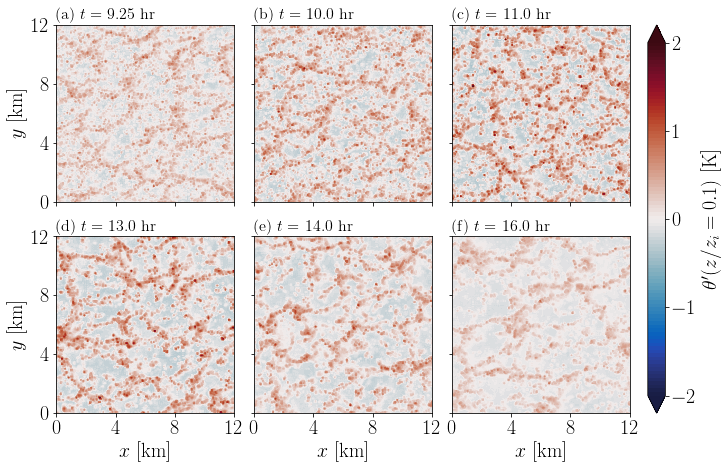

In [11]:
# loop over sims and plot for z = 100 m
# jz = abs(d1.z - 100.0).argmin()
# make 6-panel plot
fig1, ax1 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 6.4))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
levelt = np.linspace(-2, 2, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax1.flatten()):
    # calc z/zi
    # calculate zi
    jzi = d1.tw.isel(time=jt).mean(dim=("x","y")).argmin().values
    zzi = d1.z/d1.z[jzi]
    # find jz for z/zi = 0.1
    jz = abs(zzi - 0.1).argmin()
    # contour
    cfax = iax.contourf(d1.x/1000, d1.y/1000, d1.theta_pert.isel(time=jt, z=jz).T,
                        levels=levelt, cmap=cmocean.cm.balance, extend="both")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig1.colorbar(cfax1[0], ax=ax1[:,-1], location="right", ticks=MultipleLocator(1))
# cb label
cb.ax.set_ylabel(f"$\\theta'(z/z_i=0.1)$ [K]")
# axis limits
ax1[0,0].set_xlim([0, 12])
ax1[0,0].set_ylim([0, 12])
# axis ticks
ax1[0,0].xaxis.set_major_locator(MultipleLocator(4))
ax1[0,0].yaxis.set_major_locator(MultipleLocator(4))
# axis labels
for iax in ax1[:,0]:
    iax.set_ylabel("$y$ [km]")
for iax in ax1[-1,:]:
    iax.set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax1.flatten(), list("abcdef"))):
    iax.set_title(f"({lab}) $t =$ {9+d1.time[jt].values} hr", fontsize=16, loc="left")

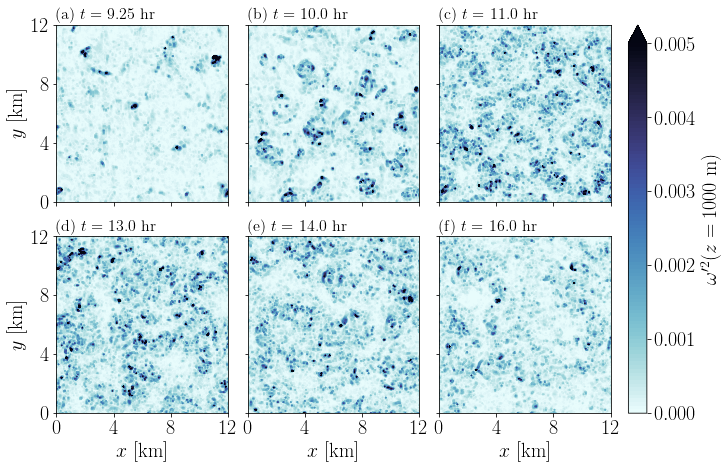

In [69]:
# loop over sims and plot for z/zi = 0.1
# make 6-panel plot
fig1, ax1 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 6.4))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
levelw = np.linspace(0, 0.005, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax1.flatten()):
    # calc z/zi
    # calculate zi
    jzi = d1.tw.isel(time=jt).mean(dim=("x","y")).argmin().values
    zzi = d1.z/d1.z[jzi]
    # find jz for z/zi = 0.1
    jz = abs(d1.z - 1000).argmin()
    # contour
    cfax = iax.contourf(d1.x/1000, d1.y/1000, d1.vort_mag_2.isel(time=jt, z=jz).T,
                        levels=levelw, cmap=cmocean.cm.ice_r, extend="max")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig1.colorbar(cfax1[0], ax=ax1[:,-1], location="right", ticks=MultipleLocator(0.001))
# cb label
cb.ax.set_ylabel("$\\omega'^2(z=1000$ m)")
# axis limits
ax1[0,0].set_xlim([0, 12])
ax1[0,0].set_ylim([0, 12])
# axis ticks
ax1[0,0].xaxis.set_major_locator(MultipleLocator(4))
ax1[0,0].yaxis.set_major_locator(MultipleLocator(4))
# axis labels
for iax in ax1[:,0]:
    iax.set_ylabel("$y$ [km]")
for iax in ax1[-1,:]:
    iax.set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax1.flatten(), list("abcdef"))):
    iax.set_title(f"({lab}) $t =$ {9+d1.time[jt].values} hr", fontsize=16, loc="left")
# save figure
# fsave = f"{figdir}agu2_w_zzi_6panel.png"
# fig2.savefig(fsave, dpi=900)

# x-z cross sections

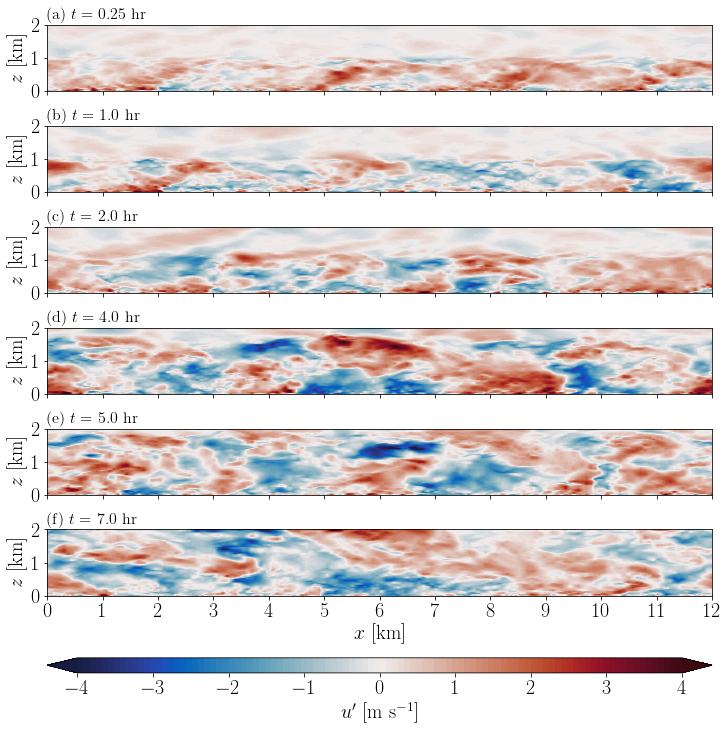

In [12]:
# loop over sims and plot for z = 100 m
jy = d1.ny // 2
# make 6-panel plot
fig1, ax1 = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 10))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
levelu = np.linspace(-4, 4, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax1.flatten()):
    # contour
    cfax = iax.contourf(d1.x/1000, d1.z/1000, d1.u_pert.isel(time=jt, y=jy).T,
                        levels=levelu, cmap=cmocean.cm.balance, extend="both")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig1.colorbar(cfax1[0], ax=ax1[:], location="bottom", ticks=MultipleLocator(1), 
                   aspect=40, pad=0.02)
# cb label
cb.ax.set_xlabel("$u'$ [m s$^{-1}$]")
# axis limits
ax1[0].set_xlim([0, 12])
ax1[0].set_ylim([0, 2])
# axis ticks
ax1[0].xaxis.set_major_locator(MultipleLocator(1))
ax1[0].yaxis.set_major_locator(MultipleLocator(1))
# axis labels
for iax in ax1:
    iax.set_ylabel("$z$ [km]")
ax1[-1].set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax1.flatten(), list("abcdef"))):
    iax.set_title(f"({lab}) $t =$ {d1.time[jt].values} hr", fontsize=16, loc="left")

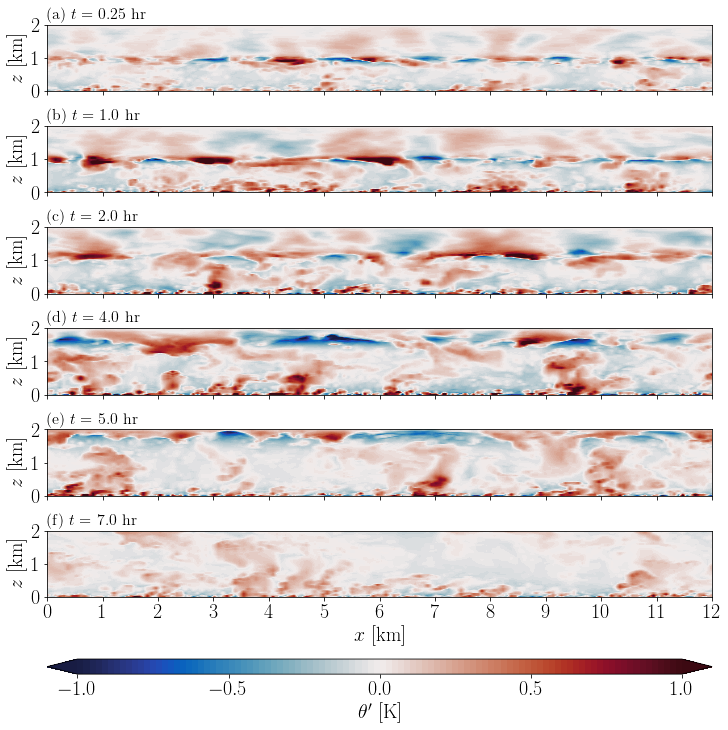

In [13]:
# loop over sims and plot for z = 100 m
jy = d1.ny // 2
# make 6-panel plot
fig1, ax1 = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 10))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
levelt = np.linspace(-1, 1, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax1.flatten()):
    # contour
    cfax = iax.contourf(d1.x/1000, d1.z/1000, d1.theta_pert.isel(time=jt, y=jy).T,
                        levels=levelt, cmap=cmocean.cm.balance, extend="both")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig1.colorbar(cfax1[0], ax=ax1[:], location="bottom", ticks=MultipleLocator(0.5), 
                   aspect=40, pad=0.02)
# cb label
cb.ax.set_xlabel("$\\theta'$ [K]")
# axis limits
ax1[0].set_xlim([0, 12])
ax1[0].set_ylim([0, 2])
# axis ticks
ax1[0].xaxis.set_major_locator(MultipleLocator(1))
ax1[0].yaxis.set_major_locator(MultipleLocator(1))
# axis labels
for iax in ax1:
    iax.set_ylabel("$z$ [km]")
ax1[-1].set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax1.flatten(), list("abcdef"))):
    iax.set_title(f"({lab}) $t =$ {d1.time[jt].values} hr", fontsize=16, loc="left")

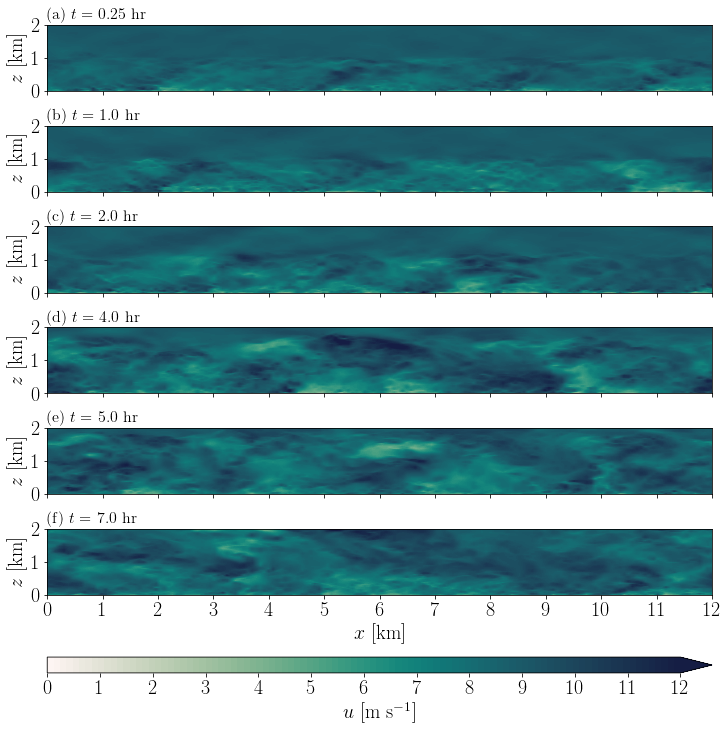

In [14]:
# loop over sims and plot for z = 100 m
jy = d1.ny // 2
# make 6-panel plot
fig1, ax1 = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 10))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
levelu = np.linspace(0, 12, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax1.flatten()):
    # contour
    cfax = iax.contourf(d1.x/1000, d1.z/1000, d1.u.isel(time=jt, y=jy).T,
                        levels=levelu, cmap=cmocean.cm.tempo, extend="max")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig1.colorbar(cfax1[0], ax=ax1[:], location="bottom", ticks=MultipleLocator(1), 
                   aspect=40, pad=0.02)
# cb label
cb.ax.set_xlabel("$u$ [m s$^{-1}$]")
# axis limits
ax1[0].set_xlim([0, 12])
ax1[0].set_ylim([0, 2])
# axis ticks
ax1[0].xaxis.set_major_locator(MultipleLocator(1))
ax1[0].yaxis.set_major_locator(MultipleLocator(1))
# axis labels
for iax in ax1:
    iax.set_ylabel("$z$ [km]")
ax1[-1].set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax1.flatten(), list("abcdef"))):
    iax.set_title(f"({lab}) $t =$ {d1.time[jt].values} hr", fontsize=16, loc="left")

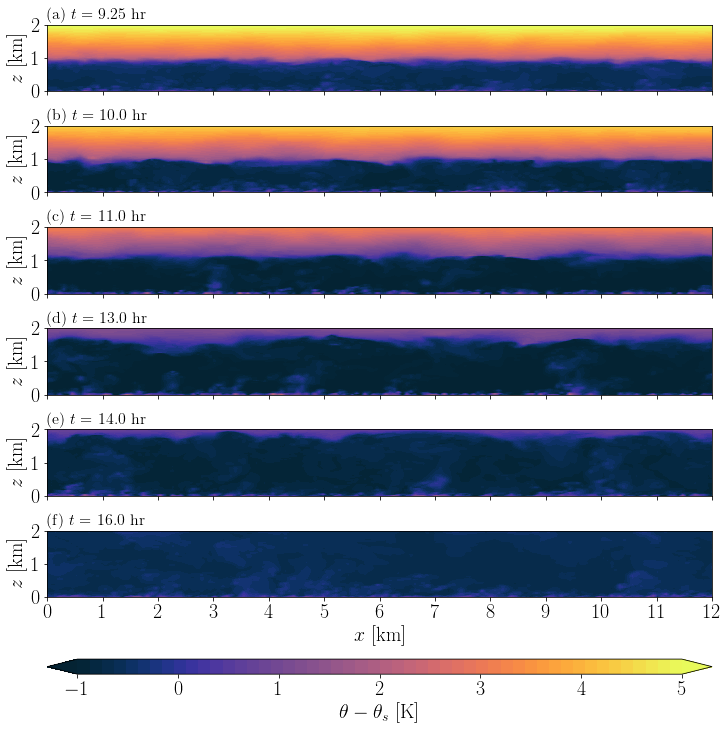

In [15]:
# loop over sims and plot for z = 100 m
jy = d1.ny // 2
# make 6-panel plot
fig1, ax1 = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 10))
# keep track of cfaxis handles
cfax1 = []
# define cbar range
levelt = np.linspace(-1, 5, 51)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax1.flatten()):
    # contour
    cfax = iax.contourf(d1.x/1000, d1.z/1000, 
                        d1.theta.isel(time=jt, y=jy).T-d1.theta.isel(time=jt,z=0).mean(dim=("x","y")),
                        levels=levelt, cmap=cmocean.cm.thermal, extend="both")
    # keep cf handle
    cfax1.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig1.colorbar(cfax1[0], ax=ax1[:], location="bottom", ticks=MultipleLocator(1), 
                   aspect=40, pad=0.02)
# cb label
cb.ax.set_xlabel("$\\theta - \\theta_s$ [K]")
# axis limits
ax1[0].set_xlim([0, 12])
ax1[0].set_ylim([0, 2])
# axis ticks
ax1[0].xaxis.set_major_locator(MultipleLocator(1))
ax1[0].yaxis.set_major_locator(MultipleLocator(1))
# axis labels
for iax in ax1:
    iax.set_ylabel("$z$ [km]")
ax1[-1].set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax1.flatten(), list("abcdef"))):
    iax.set_title(f"({lab}) $t =$ {9+d1.time[jt].values} hr", fontsize=16, loc="left")

# Case 2

In [16]:
timesteps = np.arange(648000, 1260001, 1000, dtype=np.int32)
t = (0.05 * timesteps)/3600. - 9 # reset to 0
# grab the timesteps for loading
# array of times
tload = np.array([0.25, 0.75, 1.5, 3.5, 4.25, 6.5]) # hrs
# loop to find nearest timestep
jt2 = np.array([np.argmin(np.abs(t - tt)) for tt in tload])
# number of timesteps
nt = len(tload)

In [42]:
# construct filenames
f2 = [f"{dnc_all[1]}all_{timesteps[jt]:07d}.nc" for jt in jt2]
# load mf dataset
d2 = xr.open_mfdataset(f2, combine="nested", concat_dim="time")
d2.coords["time"] = t[jt2]
d2.time.attrs["units"] = "hr"

In [43]:
f2

['/home/rfrost/sim_output/linear_flux/agu_2/all_0666000.nc',
 '/home/rfrost/sim_output/linear_flux/agu_2/all_0702000.nc',
 '/home/rfrost/sim_output/linear_flux/agu_2/all_0756000.nc',
 '/home/rfrost/sim_output/linear_flux/agu_2/all_0900000.nc',
 '/home/rfrost/sim_output/linear_flux/agu_2/all_0954000.nc',
 '/home/rfrost/sim_output/linear_flux/agu_2/all_1116000.nc']

In [63]:
# calculate "inst" covar based on xy planar averages
# averages and perturbations
for v in ["u", "v", "w", "theta"]:
    d2[f"{v}_mean"] = d2[v].mean(dim=("x", "y"))
    d2[f"{v}_pert"] = d2[v] - d2[f"{v}_mean"]
# covars
d2["uw"] = (d2.u - d2.u_mean) * (d2.w - d2.w_mean) + d2.txz
d2["vw"] = (d2.v - d2.v_mean) * (d2.w - d2.w_mean) + d2.tyz
d2["tw"] = (d2.theta - d2.theta_mean) * (d2.w - d2.w_mean) + d2.q3
# vars
d2["uu"] = (d2.u - d2.u_mean) * (d2.u - d2.u_mean)
d2["vv"] = (d2.v - d2.v_mean) * (d2.v - d2.v_mean)
d2["ww"] = (d2.w - d2.w_mean) * (d2.w - d2.w_mean)
d2["tt"] = (d2.theta - d2.theta_mean) * (d2.theta - d2.theta_mean)

# calculate averages
d2["uw_cov_tot"] = d2.uw.mean(dim=("x","y"))
d2["vw_cov_tot"] = d2.vw.mean(dim=("x","y"))
d2["tw_cov_tot"] = d2.tw.mean(dim=("x","y"))
d2["uu_var"] = d2.uu.mean(dim=("x","y"))
d2["vv_var"] = d2.vv.mean(dim=("x","y"))
d2["ww_var"] = d2.ww.mean(dim=("x","y"))
d2["tt_var"] = d2.tt.mean(dim=("x","y"))
# calculate ustar
d2["ustar2"] = ((d2.uw_cov_tot**2) + (d2.vw_cov_tot**2.)) ** 0.5
# calculate vorticity
d2["vort_x"] = d2.w_pert.differentiate("y", 2) - d2.v_pert.differentiate("z", 2)
d2["vort_y"] = d2.u_pert.differentiate("z", 2) - d2.w_pert.differentiate("x", 2)
d2["vort_z"] = d2.v_pert.differentiate("x", 2) - d2.u_pert.differentiate("y", 2)
d2["vort_mag_2"] = d2.vort_x*d2.vort_x + d2.vort_y*d2.vort_y + d2.vort_z*d2.vort_z

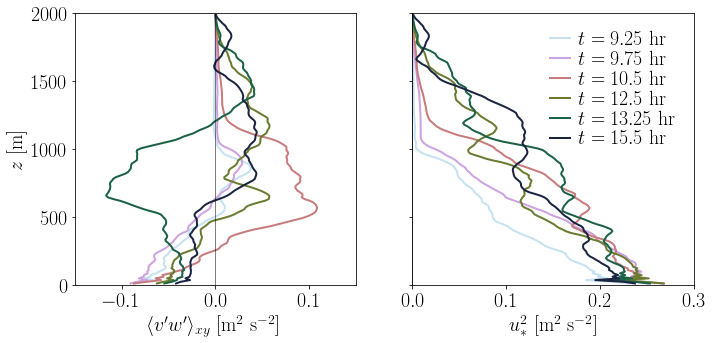

In [52]:
# plot profiles of momentum and heat flux
fig2, ax2 = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(11.1, 5))
# loop over timesteps
for jt in range(nt):
    ax2[0].plot(d2.vw_cov_tot.isel(time=jt), d2.z, label=f"$t={{{9+d2.time[jt].values}}}$ hr",
                lw=2, c=colors[jt])
    ax2[1].plot(d2.ustar2.isel(time=jt), d2.z, label=f"$t={{{9+d2.time[jt].values}}}$ hr", 
                lw=2, c=colors[jt])
# legend
ax2[1].legend(frameon=False, labelspacing=0.10,# ncol=2, columnspacing=1,
              handletextpad=0.4, handlelength=1, loc="upper right")
# axis limits
ax2[0].set_ylim([0, 2000])
ax2[0].set_xlim([-0.15, 0.15])
ax2[1].set_xlim([0, 0.3])
# axis lbels
ax2[0].set_ylabel("$z$ [m]")
ax2[0].set_xlabel("$\\langle v'w' \\rangle_{xy}$ [m$^2$ s$^{-2}$]")
ax2[1].set_xlabel("$u_*^2$ [m$^2$ s$^{-2}$]")
# vertical thin lines at 0
for iax in ax2:
    iax.axvline(0, ls="-", c="k", lw=0.5)

Text(0.5, 1.0, 'Case 2')

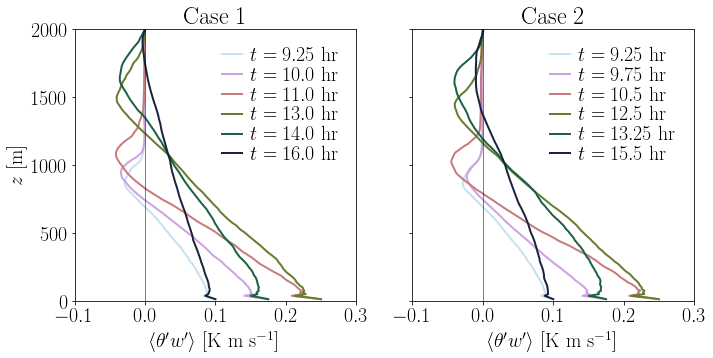

In [46]:
# plot profiles of just heat flux from cases 1 and 2
# plot profiles of momentum and heat flux
fig2, ax2 = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(11.1, 5))
# loop over timesteps
for jt in range(nt):
    ax2[0].plot(d1.tw_cov_tot.isel(time=jt), d1.z, label=f"$t={{{9+d1.time[jt].values}}}$ hr",
                lw=2, c=colors[jt])
    ax2[1].plot(d2.tw_cov_tot.isel(time=jt), d2.z, label=f"$t={{{9+d2.time[jt].values}}}$ hr", 
                lw=2, c=colors[jt])
# legend
ax2[0].legend(frameon=False, labelspacing=0.10,# ncol=2, columnspacing=1,
                handletextpad=0.4, handlelength=1, loc="upper right")
ax2[1].legend(frameon=False, labelspacing=0.10,# ncol=2, columnspacing=1,
                handletextpad=0.4, handlelength=1, loc="upper right")
# axis limits
ax2[0].set_ylim([0, 2000])
ax2[0].set_xlim([-0.1, 0.3])
# axis lbels
ax2[0].set_ylabel("$z$ [m]")
ax2[0].set_xlabel("$\\langle \\theta'w' \\rangle$ [K m s$^{-1}$]")
ax2[1].set_xlabel("$\\langle \\theta'w' \\rangle$ [K m s$^{-1}$]")
# vertical thin lines at 0
for iax in ax2:
    iax.axvline(0, ls="-", c="k", lw=0.5)
# subplot titles
ax2[0].set_title("Case 1")
ax2[1].set_title("Case 2")

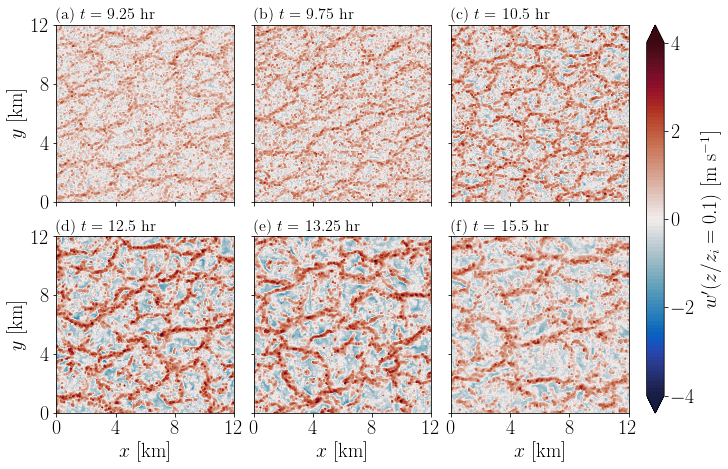

In [55]:
# loop over sims and plot for z/zi = 0.1
# make 6-panel plot
fig2, ax2 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 6.4))
# keep track of cfaxis handles
cfax2 = []
# define cbar range
levelw = np.linspace(-4, 4, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax2.flatten()):
    # calc z/zi
    # calculate zi
    jzi = d2.tw.isel(time=jt).mean(dim=("x","y")).argmin().values
    zzi = d2.z/d2.z[jzi]
    # find jz for z/zi = 0.1
    jz = abs(zzi - 0.1).argmin()
    # contour
    cfax = iax.contourf(d2.x/1000, d2.y/1000, d2.w_pert.isel(time=jt, z=jz).T,
                        levels=levelw, cmap=cmocean.cm.balance, extend="both")
    # keep cf handle
    cfax2.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig2.colorbar(cfax2[0], ax=ax2[:,-1], location="right", ticks=MultipleLocator(2))
# cb label
cb.ax.set_ylabel("$w'(z/z_i=0.1)$ [m s$^{-1}$]")
# axis limits
ax2[0,0].set_xlim([0, 12])
ax2[0,0].set_ylim([0, 12])
# axis ticks
ax2[0,0].xaxis.set_major_locator(MultipleLocator(4))
ax2[0,0].yaxis.set_major_locator(MultipleLocator(4))
# axis labels
for iax in ax2[:,0]:
    iax.set_ylabel("$y$ [km]")
for iax in ax2[-1,:]:
    iax.set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax2.flatten(), list("abcdef"))):
    iax.set_title(f"({lab}) $t =$ {9+d2.time[jt].values} hr", fontsize=16, loc="left")
# save figure
fsave = f"{figdir}agu2_w_zzi_6panel.png"
fig2.savefig(fsave, dpi=900)

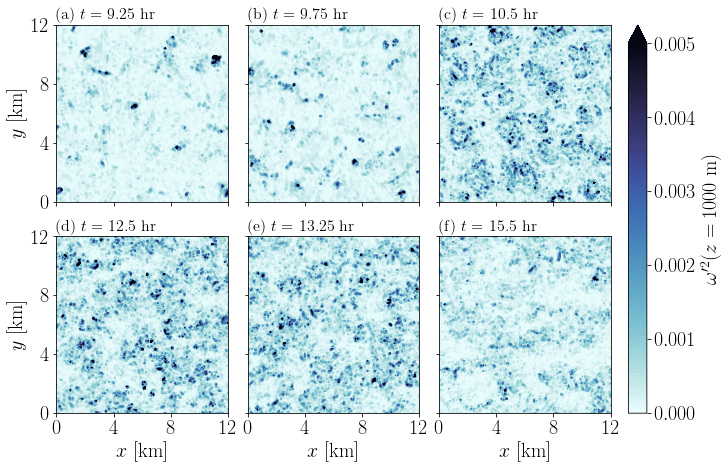

In [70]:
# loop over sims and plot for z/zi = 0.1
# make 6-panel plot
fig2, ax2 = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, 
                         constrained_layout=True, figsize=(10, 6.4))
# keep track of cfaxis handles
cfax2 = []
# define cbar range
levelw = np.linspace(0, 0.005, 101)
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax2.flatten()):
    # calc z/zi
    # calculate zi
    jzi = d2.tw.isel(time=jt).mean(dim=("x","y")).argmin().values
    zzi = d2.z/d2.z[jzi]
    # find jz for z/zi = 0.1
    jz = abs(d2.z - 1000).argmin()
    # contour
    cfax = iax.contourf(d2.x/1000, d2.y/1000, d2.vort_mag_2.isel(time=jt, z=jz).T,
                        levels=levelw, cmap=cmocean.cm.ice_r, extend="max")
    # keep cf handle
    cfax2.append(cfax)
    # cb = fig1.colorbar(cfax, ax=iax, location="right")
# one big colorbar on the right
cb = fig2.colorbar(cfax2[0], ax=ax2[:,-1], location="right", ticks=MultipleLocator(0.001))
# cb label
cb.ax.set_ylabel("$\\omega'^2(z=1000$ m)")
# axis limits
ax2[0,0].set_xlim([0, 12])
ax2[0,0].set_ylim([0, 12])
# axis ticks
ax2[0,0].xaxis.set_major_locator(MultipleLocator(4))
ax2[0,0].yaxis.set_major_locator(MultipleLocator(4))
# axis labels
for iax in ax2[:,0]:
    iax.set_ylabel("$y$ [km]")
for iax in ax2[-1,:]:
    iax.set_xlabel("$x$ [km]")
# figure titles
for jt, (iax, lab) in enumerate(zip(ax2.flatten(), list("abcdef"))):
    iax.set_title(f"({lab}) $t =$ {9+d2.time[jt].values} hr", fontsize=16, loc="left")
# save figure
# fsave = f"{figdir}agu2_w_zzi_6panel.png"
# fig2.savefig(fsave, dpi=900)

$u_*^2 = (\langle u'w' \rangle^2 + \langle v'w' \rangle^2)^{1/2}$